# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [9]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
02Feb2006Kennedy7.txt,FOR IMMEDIATE RELEASE Lithonia Geor...
07Jun2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
28Sep2006Kennedy7.txt,FOR IMMEDIATE RELEASE Washington D...
18Apr2007Kennedy14.txt,FOR IMMEDIATE RELEASE I am pleased t...
29Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Washington ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [10]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
02Feb2006Kennedy7.txt,FOR IMMEDIATE RELEASE Lithonia Geor...,Kennedy
07Jun2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
28Sep2006Kennedy7.txt,FOR IMMEDIATE RELEASE Washington D...,Kennedy
18Apr2007Kennedy14.txt,FOR IMMEDIATE RELEASE I am pleased t...,Kennedy
29Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [11]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
22May2008Klobuchar45.txt,...,Klobuchar
02Nov2007Klobuchar188.txt,...,Klobuchar
28May2008Klobuchar41.txt,...,Klobuchar
06Jun2007Klobuchar303.txt,...,Klobuchar
18Sep2007Klobuchar222.txt,...,Klobuchar


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [12]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
22May2008Klobuchar45.txt,...,Klobuchar,"[[Klobuchar, Features, Fergus, Falls, Bakery, ...","[[klobuchar, features, fergus, falls, bakery, ..."
02Nov2007Klobuchar188.txt,...,Klobuchar,"[[Senator, Klobuchar, Seeks, to, Prohibit, Ind...","[[senator, klobuchar, seeks, prohibit, industr..."
28May2008Klobuchar41.txt,...,Klobuchar,"[[Klobuchar, Meets, with, Local, Burmese, Comm...","[[klobuchar, meets, local, burmese, community,..."
06Jun2007Klobuchar303.txt,...,Klobuchar,"[[Klobuchar, Introduces, Renewable, Energy, In...","[[klobuchar, introduces, renewable, energy, in..."
18Sep2007Klobuchar222.txt,...,Klobuchar,"[[Senator, Klobuchar, Applauds, Senate, Passag...","[[senator, klobuchar, applauds, senate, passag..."


In [ ]:
senReleasesDF['normalized_sents'].iloc[0]

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [ ]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

If you want the full matrix, `syn0` stores all the vectors:

In [ ]:
senReleasesW2V.wv.syn0

Then, `index2word` lets you translate from the matrix to words

In [ ]:
senReleasesW2V.wv.index2word[10]

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [ ]:
senReleasesW2V.most_similar('president')

In [ ]:
senReleasesW2V.most_similar('war')

Or we can get this directly (calculated slightly differently):

In [ ]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [ ]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

We can also find which word least matches the others within a word set (cosine similarity):

In [ ]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [ ]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [ ]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

In [ ]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [ ]:
senReleasesDF[sample_indices == i]

In [ ]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

In [ ]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [ ]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [ ]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [ ]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [ ]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

In [ ]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

Now we have the training loss and can optimize training to minimize it.

In [ ]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

In [ ]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [ ]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

In [ ]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [2]:
import re

In [3]:
# read csv into a DF
djDF = pandas.read_csv('dj_bible_all')

# create an index for the dataframe
djDF['index'] = range(len(djDF))

# use regex to strip out html elements from corpora
for x in range(0, len(djDF)):
   djDF.iloc[x,1] = re.sub('<[^<]+?>', '', djDF.iloc[x,1])

In [4]:
# tokenize the data
djDF['tokenized_sents'] = djDF['post'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
djDF['normalized_sents'] = djDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

In [5]:
djW2V = gensim.models.word2vec.Word2Vec(djDF['normalized_sents'].sum())

In [18]:
# Interrogate some word relationships
# find similar vectors by consine similarity
djW2V.most_similar('guy')

[('jerk', 0.8977867364883423),
 ('wimps', 0.8899115324020386),
 ('pervert', 0.8806747794151306),
 ('seperates', 0.8722873330116272),
 ('man', 0.8711382150650024),
 ('syndrome', 0.8702548742294312),
 ('moderation', 0.8701784610748291),
 ('sink', 0.8681151866912842),
 ('hotel', 0.865714430809021),
 ('smells', 0.8644935488700867)]

In [19]:
djW2V.most_similar('sex')

[('approach', 0.9973943829536438),
 ('meet', 0.9970903992652893),
 ('chick', 0.9957576990127563),
 ('trying', 0.9942822456359863),
 ('laid', 0.993569552898407),
 ('attention', 0.9932692050933838),
 ('times', 0.9930588603019714),
 ('fun', 0.9930522441864014),
 ('spend', 0.9925084114074707),
 ('talking', 0.9918403625488281)]

In [20]:
djW2V.most_similar('love')

[('real', 0.991244375705719),
 ('respect', 0.9911054968833923),
 ('attract', 0.9906629920005798),
 ('fact', 0.990535318851471),
 ('attractive', 0.9898992776870728),
 ('confident', 0.9896820187568665),
 ('fall', 0.9892457723617554),
 ('understand', 0.9891051650047302),
 ('kind', 0.9888695478439331),
 ('realize', 0.9886477589607239)]

In [21]:
djW2V.most_similar('man')

[('sting', 0.9878084659576416),
 ('cynetix', 0.9873387217521667),
 ('adventure', 0.9867685437202454),
 ('stockholder', 0.986359179019928),
 ('button', 0.984459400177002),
 ('metal', 0.9842702746391296),
 ('adonis', 0.9838914275169373),
 ('rico', 0.9838409423828125),
 ('neo', 0.9834412336349487),
 ('performer', 0.9833385944366455)]

In [22]:
djW2V.most_similar('woman')

[('wants', 0.9835636019706726),
 ('less', 0.9830718636512756),
 ('away', 0.9828516244888306),
 ('around', 0.9825867414474487),
 ('control', 0.9825765490531921),
 ('beautiful', 0.981996476650238),
 ('walk', 0.9811891913414001),
 ('care', 0.9810426831245422),
 ('attention', 0.9810394644737244),
 ('either', 0.9798558354377747)]

In [23]:
djW2V.most_similar('relationship')

[('enough', 0.9979092478752136),
 ('stop', 0.9974300861358643),
 ('chicks', 0.9973071217536926),
 ('sometimes', 0.9970928430557251),
 ('learn', 0.9965812563896179),
 ('probably', 0.9965713620185852),
 ('expect', 0.9965043663978577),
 ('laugh', 0.9963930249214172),
 ('see', 0.9960347414016724),
 ('easier', 0.9959436058998108)]

In [24]:
djW2V.most_similar('girlfriend')

[('tried', 0.998892068862915),
 ('didnt', 0.998734712600708),
 ('serious', 0.9986964464187622),
 ('wonder', 0.998670220375061),
 ('possible', 0.9985984563827515),
 ('easy', 0.9985126852989197),
 ('figure', 0.9983727335929871),
 ('probably', 0.9983257055282593),
 ('along', 0.9982609748840332),
 ('imagine', 0.9981750249862671)]

In [25]:
# explore semantic equations
djW2V.most_similar(positive=['sex', 'woman'], negative = ['man'])

[('talk', 0.9731433391571045),
 ('want', 0.971768856048584),
 ('get', 0.9708028435707092),
 ('number', 0.9686764478683472),
 ('date', 0.9676327705383301),
 ('go', 0.9663957953453064),
 ('girl', 0.9645773768424988),
 ('ask', 0.9636945128440857),
 ('interested', 0.9626287221908569),
 ('call', 0.9613762497901917)]

In [26]:
djW2V.most_similar(positive=['love', 'woman'], negative = ['man'])

[('get', 0.9846338033676147),
 ('interested', 0.983426034450531),
 ('talk', 0.9812682271003723),
 ('girls', 0.9750082492828369),
 ('want', 0.9738503098487854),
 ('go', 0.9719415903091431),
 ('ask', 0.9658171534538269),
 ('friends', 0.9652941226959229),
 ('find', 0.9639054536819458),
 ('never', 0.9638746976852417)]

In [27]:
djW2V.most_similar(positive=['woman', 'sex'], negative = ['man'])

[('talk', 0.9731433391571045),
 ('want', 0.971768856048584),
 ('get', 0.9708028435707092),
 ('number', 0.9686764478683472),
 ('date', 0.9676327705383301),
 ('go', 0.9663957953453064),
 ('girl', 0.9645773768424988),
 ('ask', 0.9636945128440857),
 ('interested', 0.9626287221908569),
 ('call', 0.9613762497901917)]

In [28]:
#visualize the word embeddings
numWords = 300
djtargetWords = djW2V.wv.index2word[:numWords]

djwordsSubMatrix = []
for word in djtargetWords:
    djwordsSubMatrix.append(djW2V[word])
djwordsSubMatrix = np.array(djwordsSubMatrix)

In [29]:
# use pca to reduce data to 50 dimensions
djpcaWords = sklearn.decomposition.PCA(n_components = 50).fit(djwordsSubMatrix)
djreduced = djpcaWords.transform(djwordsSubMatrix)
djtsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(djreduced)

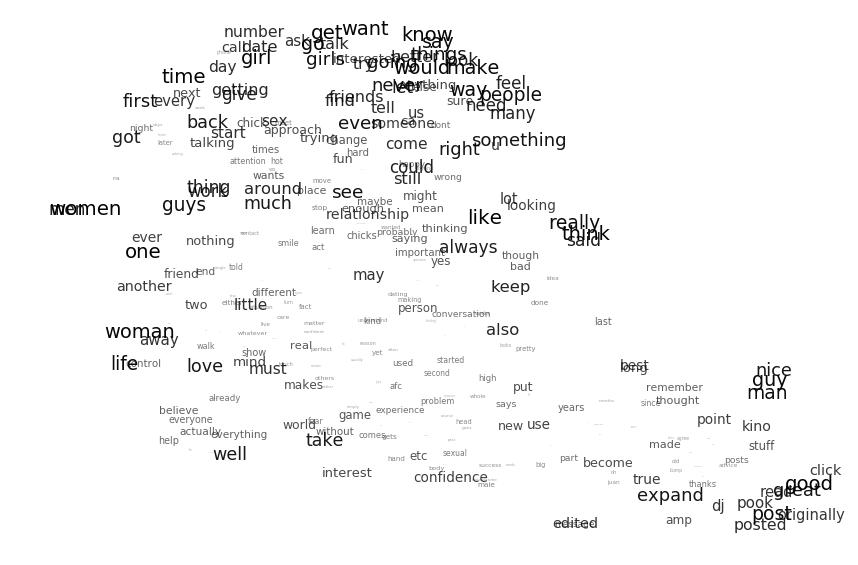

In [30]:
#plot
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(djtsneWords[:, 0], djtsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(djtargetWords):
    ax.annotate(word, 
                (djtsneWords[:, 0][i],djtsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [ ]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [ ]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [ ]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [ ]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [ ]:
apsD2V.docvecs[1952]

The words can still be accessed in the same way:

In [ ]:
apsD2V['atom']

We can still use the ``most_similar`` command to perform simple semantic equations:

In [ ]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [ ]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

In [ ]:
djD2V.docvecs['']

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

We can even look for documents most like a query composed of multiple words:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

Now let's plot some words and documents against one another with a heatmap:

In [ ]:
keywords

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [ ]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

In [31]:
# read csv into a DF
djDF2 = pandas.read_csv('dj_bible_all')

# create an index for the dataframe
djDF2['index'] = range(len(djDF))

# use regex to strip out html elements from corpora
for x in range(0, len(djDF2)):
   djDF2.iloc[x,1] = re.sub('<[^<]+?>', '', djDF2.iloc[x,1])

djmainDF = djDF2.loc[djDF2['post_no']<1,:]

djmainDF['tokenized_words'] = djmainDF['post'].apply(lambda x: nltk.word_tokenize(x))
djmainDF['normalized_words'] = djmainDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

# I don't have a document ID that's native to my text, so I'll just assign the index as the doc id
djmainDF = djmainDF.reset_index()
djmainDF['docID'] = djmainDF.index

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
djkeywords = ['sex', 'love', 'girlfriend', 'confidence', 'money', 'gym', 'power', 'number', 'chat', 'kiss', 'touch', 'porn']

In [33]:
djtaggedDocs = []
for index, row in djmainDF.iterrows():
    #Just doing a simple keyword assignment
    djdocKeywords = [s for s in djkeywords if s in row['normalized_words']]
    djdocKeywords.append(row['docID'])
    djdocKeywords.append(row['url'])
    djtaggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = djdocKeywords))
djmainDF['tagged'] = djtaggedDocs

In [34]:
#train d2v model
djD2V = gensim.models.doc2vec.Doc2Vec(djmainDF['tagged'], size = 100) #Limiting to 100 dimensions

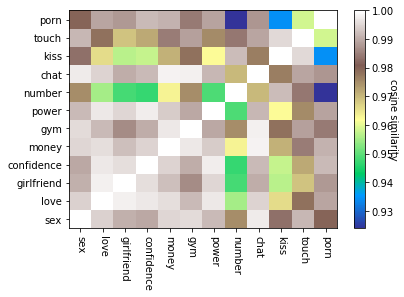

In [35]:
# heat map that compares keywords with one another
djheatmapMatrix = []
for tagOuter in djkeywords:
    column = []
    tagVec = djD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in djkeywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, djD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    djheatmapMatrix.append(column)
djheatmapMatrix = np.array(djheatmapMatrix)

fig, ax = plt.subplots()
hmap = ax.pcolor(djheatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(djheatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(djheatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(djkeywords, minor=False, rotation=270)
a = ax.set_yticklabels(djkeywords, minor=False)

One observation from the heat map is that certain of the keywords I identified have similar variations in cosine similarity. ``touch``, ``kiss``, ``number`` constitue one such group; ``money``, `confidence`, ``power``, `gym` are one, and ``girlfriend`` and ``love`` yet another). 

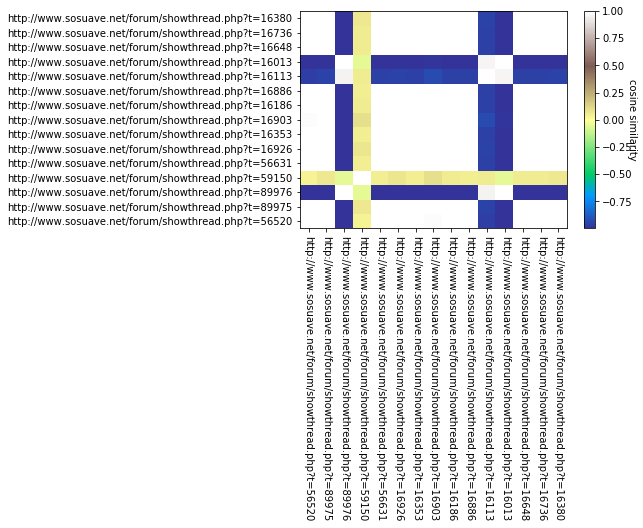

In [36]:
# heatmap that compares documents against documents
djtargetDocs = djmainDF['url'][:15]

djheatmapMatrixD = []

for tagOuter in djtargetDocs:
    column = []
    tagVec = djD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in djtargetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, djD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    djheatmapMatrixD.append(column)
djheatmapMatrixD = np.array(djheatmapMatrixD)

fig, ax = plt.subplots()
hmap = ax.pcolor(djheatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(djheatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(djheatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(djtargetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(djtargetDocs, minor=False)

There seems to be a lot of regularity to the posts. I need to look into why that is.

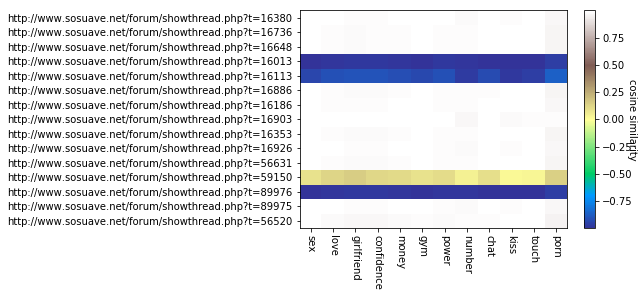

In [37]:
# heatmap that compares documents against keywords
djheatmapMatrixC = []

for tagOuter in djtargetDocs:
    column = []
    tagVec = djD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in djkeywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, djD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    djheatmapMatrixC.append(column)
djheatmapMatrixC = np.array(djheatmapMatrixC)

fig, ax = plt.subplots()
hmap = ax.pcolor(djheatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(djheatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(djheatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(djkeywords, minor=False, rotation=270)
a = ax.set_yticklabels(djtargetDocs, minor=False)

It would seem that sex is semantically similar to many of these documents. I'm not quite sure what to make of this, especially since this is only a snapshot of 10 of the documents ...

In [38]:
djtargetDocs

0     http://www.sosuave.net/forum/showthread.php?t=...
1     http://www.sosuave.net/forum/showthread.php?t=...
2     http://www.sosuave.net/forum/showthread.php?t=...
3     http://www.sosuave.net/forum/showthread.php?t=...
4     http://www.sosuave.net/forum/showthread.php?t=...
5     http://www.sosuave.net/forum/showthread.php?t=...
6     http://www.sosuave.net/forum/showthread.php?t=...
7     http://www.sosuave.net/forum/showthread.php?t=...
8     http://www.sosuave.net/forum/showthread.php?t=...
9     http://www.sosuave.net/forum/showthread.php?t=...
10    http://www.sosuave.net/forum/showthread.php?t=...
11    http://www.sosuave.net/forum/showthread.php?t=...
12    http://www.sosuave.net/forum/showthread.php?t=...
13    http://www.sosuave.net/forum/showthread.php?t=...
14    http://www.sosuave.net/forum/showthread.php?t=...
Name: url, dtype: object

I'll compare the cosine-similarities of all the documents to a select few words: ``sex``, ``love``, ``girlfriend``, ``confidence``.

In [39]:
sexcos = []
for index, row in djmainDF.iterrows():
    sexcos.append(sklearn.metrics.pairwise.cosine_similarity(djD2V.docvecs[row['url']].reshape(1, -1),djD2V['sex'].reshape(1,-1)))
sexcos   

[array([[0.99768674]], dtype=float32),
 array([[0.9995054]], dtype=float32),
 array([[-0.9990675]], dtype=float32),
 array([[0.06288355]], dtype=float32),
 array([[0.99945724]], dtype=float32),
 array([[0.9995463]], dtype=float32),
 array([[0.9989818]], dtype=float32),
 array([[0.99585545]], dtype=float32),
 array([[0.99970967]], dtype=float32),
 array([[0.99891376]], dtype=float32),
 array([[-0.9528847]], dtype=float32),
 array([[-0.99788654]], dtype=float32),
 array([[0.9995678]], dtype=float32),
 array([[0.9997278]], dtype=float32),
 array([[0.9989606]], dtype=float32),
 array([[0.9988935]], dtype=float32),
 array([[0.99745065]], dtype=float32),
 array([[0.9992653]], dtype=float32),
 array([[0.9979989]], dtype=float32),
 array([[0.9996546]], dtype=float32),
 array([[0.9995231]], dtype=float32),
 array([[-0.9984889]], dtype=float32),
 array([[0.99585587]], dtype=float32),
 array([[0.9995912]], dtype=float32),
 array([[0.99948233]], dtype=float32),
 array([[0.9993384]], dtype=float32)

In [40]:
lovecos = []
for index, row in djmainDF.iterrows():
    lovecos.append(sklearn.metrics.pairwise.cosine_similarity(djD2V.docvecs[row['url']].reshape(1, -1),djD2V['love'].reshape(1,-1)))
lovecos   

[array([[0.9963367]], dtype=float32),
 array([[0.9996803]], dtype=float32),
 array([[-0.9980588]], dtype=float32),
 array([[0.07090943]], dtype=float32),
 array([[0.9986768]], dtype=float32),
 array([[0.9995951]], dtype=float32),
 array([[0.9982599]], dtype=float32),
 array([[0.9976825]], dtype=float32),
 array([[0.9994063]], dtype=float32),
 array([[0.9980747]], dtype=float32),
 array([[-0.9467302]], dtype=float32),
 array([[-0.99672693]], dtype=float32),
 array([[0.9991628]], dtype=float32),
 array([[0.9992859]], dtype=float32),
 array([[0.9994667]], dtype=float32),
 array([[0.99850976]], dtype=float32),
 array([[0.9966147]], dtype=float32),
 array([[0.9985966]], dtype=float32),
 array([[0.9976673]], dtype=float32),
 array([[0.99916494]], dtype=float32),
 array([[0.99922395]], dtype=float32),
 array([[-0.99889755]], dtype=float32),
 array([[0.9956886]], dtype=float32),
 array([[0.9991598]], dtype=float32),
 array([[0.9991799]], dtype=float32),
 array([[0.99908936]], dtype=float32),
 

In [41]:
gfcos = []
for index, row in djmainDF.iterrows():
    gfcos.append(sklearn.metrics.pairwise.cosine_similarity(djD2V.docvecs[row['url']].reshape(1, -1),djD2V['girlfriend'].reshape(1,-1)))
gfcos   

[array([[0.9976822]], dtype=float32),
 array([[0.9994068]], dtype=float32),
 array([[-0.9990689]], dtype=float32),
 array([[0.0626379]], dtype=float32),
 array([[0.99926805]], dtype=float32),
 array([[0.99943155]], dtype=float32),
 array([[0.9989636]], dtype=float32),
 array([[0.9956881]], dtype=float32),
 array([[0.9996031]], dtype=float32),
 array([[0.998793]], dtype=float32),
 array([[-0.9529227]], dtype=float32),
 array([[-0.9977058]], dtype=float32),
 array([[0.99950975]], dtype=float32),
 array([[0.9996683]], dtype=float32),
 array([[0.99874157]], dtype=float32),
 array([[0.99887484]], dtype=float32),
 array([[0.99766177]], dtype=float32),
 array([[0.9990032]], dtype=float32),
 array([[0.9981469]], dtype=float32),
 array([[0.999408]], dtype=float32),
 array([[0.9995882]], dtype=float32),
 array([[-0.99825794]], dtype=float32),
 array([[0.9958921]], dtype=float32),
 array([[0.99952567]], dtype=float32),
 array([[0.9993969]], dtype=float32),
 array([[0.9993859]], dtype=float32),
 a

In [42]:
confcos = []
for index, row in djmainDF.iterrows():
    confcos.append(sklearn.metrics.pairwise.cosine_similarity(djD2V.docvecs[row['url']].reshape(1, -1),djD2V['confidence'].reshape(1,-1)))
confcos   

[array([[0.99644625]], dtype=float32),
 array([[0.9997583]], dtype=float32),
 array([[-0.9979783]], dtype=float32),
 array([[0.0683201]], dtype=float32),
 array([[0.9987371]], dtype=float32),
 array([[0.9995147]], dtype=float32),
 array([[0.9984522]], dtype=float32),
 array([[0.9973875]], dtype=float32),
 array([[0.9994151]], dtype=float32),
 array([[0.9981005]], dtype=float32),
 array([[-0.94717574]], dtype=float32),
 array([[-0.9964716]], dtype=float32),
 array([[0.9991824]], dtype=float32),
 array([[0.99933517]], dtype=float32),
 array([[0.9993981]], dtype=float32),
 array([[0.9985686]], dtype=float32),
 array([[0.9966538]], dtype=float32),
 array([[0.998546]], dtype=float32),
 array([[0.9978728]], dtype=float32),
 array([[0.999191]], dtype=float32),
 array([[0.99922144]], dtype=float32),
 array([[-0.99886847]], dtype=float32),
 array([[0.99611795]], dtype=float32),
 array([[0.9992102]], dtype=float32),
 array([[0.9991612]], dtype=float32),
 array([[0.9992764]], dtype=float32),
 arr

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [43]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [44]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [59]:
tnytTargetWords

['man',
 'him',
 'he',
 'woman',
 'her',
 'she',
 'black',
 'blacks',
 'African',
 'white',
 'whites',
 'Caucasian',
 'rich',
 'richer',
 'richest',
 'expensive',
 'wealthy',
 'poor',
 'poorer',
 'poorest',
 'cheap',
 'inexpensive',
 'doctor',
 'lawyer',
 'plumber',
 'scientist',
 'hairdresser',
 'nanny',
 'carpenter',
 'entrepreneur',
 'musician',
 'writer',
 'banker',
 'poet',
 'nurse',
 'steak',
 'bacon',
 'croissant',
 'cheesecake',
 'salad',
 'cheeseburger',
 'vegetables',
 'beer',
 'wine',
 'pastry',
 'basketball',
 'baseball',
 'boxing',
 'softball',
 'volleyball',
 'tennis',
 'golf',
 'hockey',
 'soccer']

In [45]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

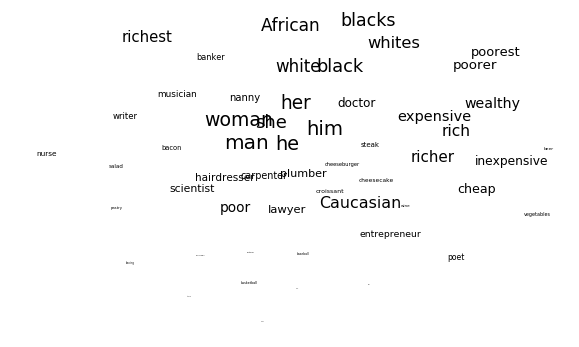

In [46]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [50]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [61]:
djW2V

In [51]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [52]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [53]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [54]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [55]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

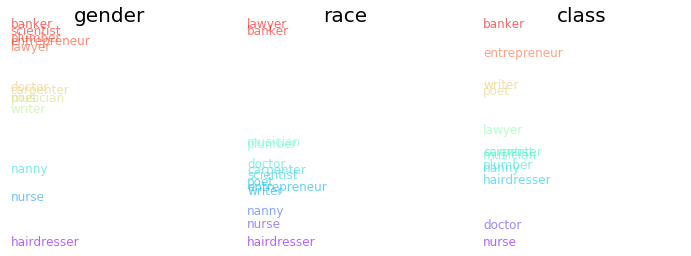

In [56]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

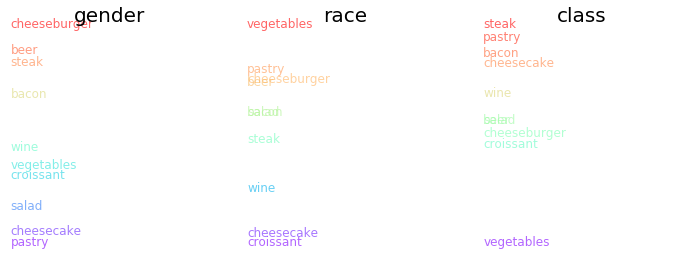

In [57]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

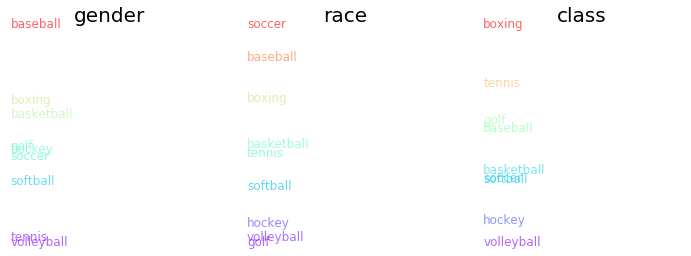

In [58]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

In [70]:
# load helper functions from above
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def djmakeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(djW2V[word].reshape(1,-1), genderdj.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(djW2V[word].reshape(1,-1), classdj.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'class': c}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [106]:
# two dimensions
genderdj = dimension(djW2V, ['man', 'men', 'guy', 'dude', 'bro'], ['woman', 'girl', 'women', 'chick', 'gal'])
classdj = dimension(djW2V, ['rich', 'expensive'], ['poor','cheap'])

# word list
activities = ['date', 'shop', 'eat','gym', 'work', 'drive', 'laugh', 'think', 'lie', 'seduce', 'wait', 'marry']
sex_acts = ['talk','flirt', 'touch', 'grab', 'kiss', 'sex']
emotions = ['happy', 'high', 'sad', 'satisfied', 'horny', 'aroused', 'wet', 'hard', 'mature', 'immature', 'child', 'silly', 'stupid']

In [107]:
#project
actDF = djmakeDF(djW2V, activities)
sexDF = djmakeDF(djW2V, sex_acts)
emoDF = djmakeDF(djW2V, emotions)

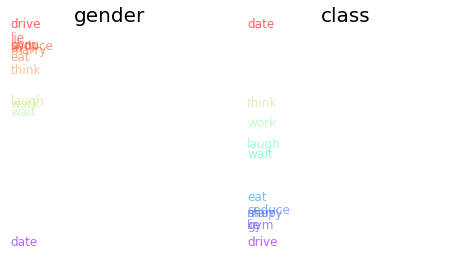

In [108]:
#plot
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, actDF, 'gender')
ax3 = fig.add_subplot(132)
PlotDimension(ax3, actDF, 'class')
plt.show()

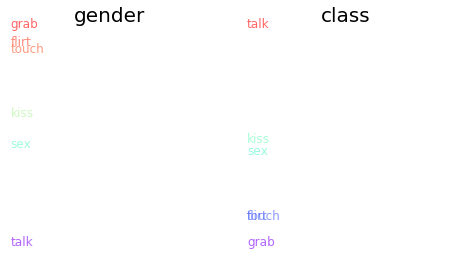

In [109]:
#plot
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, sexDF, 'gender')
ax3 = fig.add_subplot(132)
PlotDimension(ax3, sexDF, 'class')
plt.show()

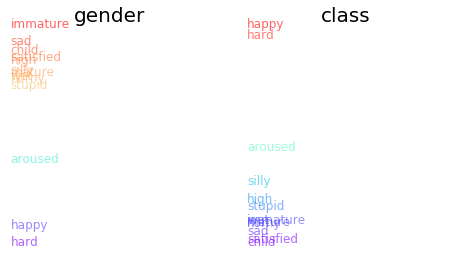

In [110]:
#plot
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, emoDF, 'gender')
ax3 = fig.add_subplot(132)
PlotDimension(ax3, emoDF, 'class')
plt.show()

What is one to make of the data above? It's hard to say. I'm wary of the class analysis since I had a fairly small pool of words that discriminated between the "higher" and "lower" classes, so I'll restrict myself to the gender dimension. Since the corpus I'm analyising pertains to seduction and the pursuit of women, you'd expect there to be an obvious gendered dimension to the material. From the first graph, we can see that sexually forward actions tend to be more masculine. There are some surprises, however. "Shop" is associated with man, and so is "eat"; "drive" is masculine, but this is a cultural stereotype so it isn't surprising. 

When we look at actions in the sexual domain, we can see even more clearly that sexually aggresive behavior is seen as masculine. It is masculine to "grab", "flirt", or "touch"; 'sex' and 'kiss' are fairly gender-equitable. Talking is feminine. I wonder where "fuck" would fit in: unfortunately, this seems to have been stripped from my corpus by nltk.

I thought a gendered analysis of common adjectives, esp. as it pertains to emotions, might be interesting. Not quite so: they mostly cluster under men. "Hard" is feminine — which I find fairly amusing. I'd have to look at this further ...